# Analysis and Prediction of Car Complaint and Recall Data 
## By Eric Murphy

When beginning in the process of trying to buy a new car a customer is often concerned with many details of how the car will perform far into the future, from depreciation, maintainance costs, safety, reliability, etc. All of these are greatly affected by the quality of the manufactured systems. Fortunately, the government has been keeping track of customer compaints for some time that are accessible from https://www-odi.nhtsa.dot.gov/downloads/. Customers often rely on sites such as kelly blue book where they can see the value of past vehicles in the current day, but there are not many resources in one place that show past complaints and recalls in a digestible manner. My own personal experience with car maintainance has found me scouring brand centered forums as well as the above governmental website about particular problems. In my own experience, folks also often employ their biases on particular aspects of a car brand when trying to narrow down their car selection that may not at all be based on current facts - e.g. Dodge's often suffer from transmission problems.

This project/notebook aims to answer many of these questions and possibly correct biases by looking at the data and making comparisons with context to other brands. We may answer questions in the context of the larger car market such as, Which car brand suffers from the least amount of major complaints? Does a Ford produce a better transmission than Dodge in their light duty trucks? More importantly, I would like to identify larger trends that may be able to predict the sort of problems that could pop up in the future for a potential car purchase by analyzing time series data. We can also look at other details of interest such as how seriously a manufacturer takes such complaints by looking at both how often high frequency complaints lead to recalls and how the problem evolves in future iterations of the product.

In [1]:
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Give the headers of the file
CMPLheader = ['CMPLID', 'ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH', 'FAILDATE', \
              'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE', 'VIN', 'DATEA', 'LDATE', \
              'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE', 'POLICE_RPT_YN', 'PURCH_DT', \
              'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', \
              'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE', \
              'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE', 'RESTRAINT_TYPE', \
              'DEALER_NAME', 'DEALER_TEL', 'DEALER_CITY', 'DEALER_STATE', 'DEALER_ZIP', 'PROD_TYPE', \
              'REPAIRED_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']

# read the data
df_Full = pd.read_csv('FLAT_Complaints/FLAT_CMPL.txt', sep='\t', low_memory=False, header=None, \
                     names=CMPLheader)


In [2]:
# convert the dates to datetime data
# want only year for the failure date
df_Full['FAILDATE'] = pd.to_datetime(df_Full['FAILDATE'], format='%Y%m%d.0', errors='coerce')
df_Full.dropna(axis=0, how='any', subset=['FAILDATE'], inplace=True)
df_Full['FAILDATE'] = df_Full['FAILDATE'].apply(lambda x: x.strftime('%Y'))
df_Full['PURCH_DT'] = pd.to_datetime(df_Full['PURCH_DT'], format='%Y%m%d.0', errors='coerce')
df_Full['MANUF_DT'] = pd.to_datetime(df_Full['MANUF_DT'], format='%Y%m%d.0', errors='coerce')
df_Full['DATEA'] = pd.to_datetime(df_Full['DATEA'], format='%Y%m%d.0', errors='coerce')
df_Full['LDATE'] = pd.to_datetime(df_Full['LDATE'], format='%Y%m%d.0', errors='coerce')

# Convert Yes/No responses to booleans
YNtoBool = {'Y':True, 'N':False}
df_Full['CRASH'] = df_Full['CRASH'].map(YNtoBool)
df_Full['FIRE'] = df_Full['FIRE'].map(YNtoBool)
df_Full['POLICE_RPT_YN'] = df_Full['POLICE_RPT_YN'].map(YNtoBool)
df_Full['ORIG_OWNER_YN'] = df_Full['ORIG_OWNER_YN'].map(YNtoBool)
df_Full['ANTI_BRAKES_YN'] = df_Full['ANTI_BRAKES_YN'].map(YNtoBool)
df_Full['CRUISE_CONT_YN'] = df_Full['CRUISE_CONT_YN'].map(YNtoBool)
df_Full['ORIG_EQUIP_YN'] = df_Full['ORIG_EQUIP_YN'].map(YNtoBool)
df_Full['REPAIRED_YN'] = df_Full['REPAIRED_YN'].map(YNtoBool)
df_Full['MEDICAL_ATTN'] = df_Full['MEDICAL_ATTN'].map(YNtoBool)
df_Full['VEHICLES_TOWED_YN'] = df_Full['VEHICLES_TOWED_YN'].map(YNtoBool)

# Display the dataframe for quick inspection
display(df_Full)

,CMPLID,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
0,1,958170.0,Ford Motor Company,MERCURY,COUGAR,1995.0,NaN,1995,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
1,2,958146.0,General Motors LLC,GMC,SONOMA,1995.0,NaN,1994,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
2,3,958149.0,"Nissan North America, Inc.",NISSAN,MAXIMA,1987.0,NaN,1994,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
4,5,958146.0,General Motors LLC,GMC,SONOMA,1995.0,NaN,1994,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
5,6,958189.0,MAZDA MOTOR CORP,MAZDA,626,1991.0,True,1994,False,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
6,7,958173.0,Ford Motor Company,LINCOLN,TOWN CAR,1994.0,True,1994,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
7,8,958146.0,General Motors LLC,GMC,SONOMA,1995.0,NaN,1994,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
8,9,958164.0,TOYOTA MOTOR CORPORATION,TOYOTA,LAND CRUISER,1994.0,NaN,1994,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
9,10,958156.0,TOYOTA MOTOR CORPORATION,TOYOTA,PASEO,1994.0,True,1994,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN
10,11,958124.0,TOYOTA MOTOR CORPORATION,TOYOTA,COROLLA,1994.0,True,1994,False,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,NaN,NaN


Now that we have the data in a suitable form for analysis, we would like to ask very macro type questions, such as what types of complaints are most frequent among a few major car manufactures. For a cross section I have chosen Toyota Motor company, Ford Motor company, BMW of North America, LLC, Honda (American Honda Motor Co.), and GENERAL MOTORS CORP/General Motors LLC.

In [3]:
# Look at the car brands with many complaints that appear under slightly different names

Car_Man_list = df_Full['MFR_NAME'].value_counts()
print(Car_Man_list[0:50])
BrandConv = {'FORD MOTOR COMPANY':'Ford Motor Company', 'GENERAL MOTORS CORP.':'General Motors LLC',\
            'GENERAL MOTORS LLC':'General Motors LLC', 'Toyota Motor Corporation':'TOYOTA MOTOR CORPORATION', \
            'TOYOTA MOTOR NORTH AMERICA, INC.':'TOYOTA MOTOR CORPORATION', \
             'HONDA (AMERICAN HONDA MOTOR CO.)':'Honda (American Honda Motor Co.)', \
             'BMW OF NORTH AMERICA, LLC':'BMW of North America, LLC' }
df_Full[['MFR_NAME']]=df_Full[['MFR_NAME']].replace(BrandConv)


General Motors LLC                          164295
Ford Motor Company                          150952
GENERAL MOTORS CORP.                        121487
FORD MOTOR COMPANY                          117726
Chrysler (FCA US LLC)                        82824
DAIMLERCHRYSLER CORPORATION                  66907
CHRYSLER GROUP LLC                           66385
TOYOTA MOTOR CORPORATION                     59577
Toyota Motor Corporation                     40728
HONDA (AMERICAN HONDA MOTOR CO.)             38621
Nissan North America, Inc.                   35236
Honda (American Honda Motor Co.)             32786
NISSAN NORTH AMERICA, INC.                   32396
Chrysler Group LLC                           30251
GENERAL MOTORS LLC                           19775
BMW of North America, LLC                    17209
VOLKSWAGEN OF AMERICA, INC                   16117
Hyundai Motor America                        15162
Volkswagen Group of America, Inc.            12809
MAZDA MOTOR CORP               

In [5]:
# now lets look at the smaller data set with the data of interest

ManfList = ['Ford Motor Company', 'General Motors LLC','TOYOTA MOTOR CORPORATION', \
            'Honda (American Honda Motor Co.)','BMW of North America, LLC']
df_manflist = df_Full.loc[df_Full['MFR_NAME'].isin(ManfList)]
irrelevantcols = ['CITY', 'STATE', 'VIN', \
              'CDESCR', 'CMPL_TYPE', 'POLICE_RPT_YN', 'PURCH_DT', \
              'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', \
              'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE', \
              'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE', 'RESTRAINT_TYPE', \
              'DEALER_NAME', 'DEALER_TEL', 'DEALER_CITY', 'DEALER_STATE', 'DEALER_ZIP', 'PROD_TYPE', \
              'REPAIRED_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']
df_manflist.drop(labels = irrelevantcols, axis=1, inplace=True)
 
# further go to individual manufacturers
df_ford = df_manflist.loc[df_manflist['MFR_NAME'].isin(['Ford Motor Company'])]
df_gm = df_manflist.loc[df_manflist['MFR_NAME'].isin(['General Motors LLC'])]
df_toyota = df_manflist.loc[df_manflist['MFR_NAME'].isin(['TOYOTA MOTOR CORPORATION'])]
df_honda = df_manflist.loc[df_manflist['MFR_NAME'].isin(['Honda (American Honda Motor Co.)'])]
df_bmw = df_manflist.loc[df_manflist['MFR_NAME'].isin(['BMW of North America, LLC'])]

ford_freq = df_ford['COMPDESC'].value_counts(normalize = True)
gm_freq = df_gm['COMPDESC'].value_counts(normalize = True)
toyota_freq = df_toyota['COMPDESC'].value_counts(normalize = True)
honda_freq = df_honda['COMPDESC'].value_counts(normalize = True)
bmw_freq = df_bmw['COMPDESC'].value_counts(normalize = True)

display(ford_freq)

C:\Users\Eric\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


VEHICLE SPEED CONTROL                                               0.059127
POWER TRAIN                                                         0.057184
ELECTRICAL SYSTEM                                                   0.052702
STEERING                                                            0.044004
AIR BAGS                                                            0.043908
ENGINE                                                              0.043223
POWER TRAIN:AUTOMATIC TRANSMISSION                                  0.040960
ENGINE AND ENGINE COOLING:ENGINE                                    0.031845
UNKNOWN OR OTHER                                                    0.026184
ENGINE AND ENGINE COOLING                                           0.022201
STRUCTURE:BODY                                                      0.021152
TIRES                                                               0.021107
SERVICE BRAKES                                                      0.021066

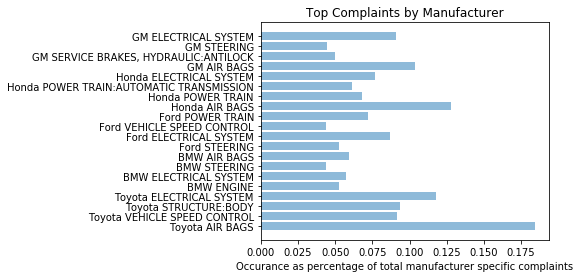

In [11]:
ford_topfreq = ford_freq.iloc[:4]
gm_topfreq = gm_freq.iloc[:4]
toyota_topfreq = toyota_freq.iloc[:4]
honda_topfreq = honda_freq.iloc[:4]
bmw_topfreq = bmw_freq.iloc[:4]

# bring all the series together for plotting
FordNames = ['Ford ' +ford_topfreq.index.values[0], 'Ford ' +ford_topfreq.index.values[1], \
              'Ford ' +ford_topfreq.index.values[2], 'Ford ' +ford_topfreq.index.values[3]]
ford_topfreq.index = FordNames
GMNames = ['GM ' +gm_topfreq.index.values[0], 'GM ' +gm_topfreq.index.values[1], \
              'GM ' +gm_topfreq.index.values[2], 'GM ' +gm_topfreq.index.values[3]]
gm_topfreq.index = GMNames
ToyotaNames = ['Toyota ' +toyota_topfreq.index.values[0], 'Toyota ' +toyota_topfreq.index.values[1], \
              'Toyota ' +toyota_topfreq.index.values[2], 'Toyota ' +toyota_topfreq.index.values[3]]
toyota_topfreq.index = ToyotaNames
HondaNames = ['Honda ' +honda_topfreq.index.values[0], 'Honda ' +honda_topfreq.index.values[1], \
              'Honda ' +honda_topfreq.index.values[2], 'Honda ' +honda_topfreq.index.values[3]]
honda_topfreq.index = HondaNames
BMWNames = ['BMW ' +bmw_topfreq.index.values[0], 'BMW ' +bmw_topfreq.index.values[1], \
              'BMW ' +bmw_topfreq.index.values[2], 'BMW ' +bmw_topfreq.index.values[3]]
bmw_topfreq.index = BMWNames

topfreq = pd.concat([ford_topfreq, gm_topfreq, toyota_topfreq, honda_topfreq, bmw_topfreq])

# Plot a Horizontal bar graph
figsize1 = (10.,4)
plt.figure(figsize=figsize1)
fig1 = plt.barh(topfreq.index, topfreq.iloc[:], align='center', alpha=0.5)
plt.yticks(topfreq.index)
plt.xlabel('Occurance as percentage of total manufacturer specific complaints')
plt.title('Top Complaints by Manufacturer')
fig1 = plt.gcf().subplots_adjust(left=0.5)
plt.show()
plt.draw()
#fig1.savefig('ComplaintManf.png', type='png', dpi=300, pad_inches=5)
plt.close()

Next we look at the the problems encountered most often by the individual manufacturers to understand some of the long term problems encountered by the manufacturer. It is clear that different manufacturers encounter different problems at vastly different frequencies. Toyota had been in the news some time ago about vehicles suddenly accelerating leading to crashed, and this appears to show up here. Some take home notes here are that for everyone but ford, air bags are leading cause of complaints. Every manufacturer has potentially high dollar complaints, such as electrical systems and transmissions. Note that we cannot yet compare between manufactureres, since we do not have the historical sales figures yet. Next we look at the data at a more microscopic model specific level.

1992.0      2
1993.0      6
1994.0     18
1995.0     11
1996.0     18
1997.0     52
1998.0     16
1999.0     15
2000.0     16
2001.0    176
2002.0    153
2003.0     98
2004.0     95
2005.0     87
2006.0    132
2007.0    134
2008.0    138
2009.0     76
2010.0     76
2011.0     36
2012.0     90
2013.0     47
2014.0     16
2015.0     18
2016.0     11
2017.0      8
Name: YEARTXT, dtype: int64

1901     2
2006     5
2007     5
2008     4
2009     2
2010     4
2011     3
2012     2
2013     6
2014    10
2015    10
2016    71
2017     8
Name: FAILDATE, dtype: int64

1901     1
2007     5
2008     4
2009     3
2010     5
2011     3
2012     6
2013    10
2014     9
2015     9
2016    70
2017     7
2018     2
Name: FAILDATE, dtype: int64

2009     3
2010     2
2011     3
2012    10
2013     4
2014    13
2015    11
2016    71
2017    18
2018     3
Name: FAILDATE, dtype: int64

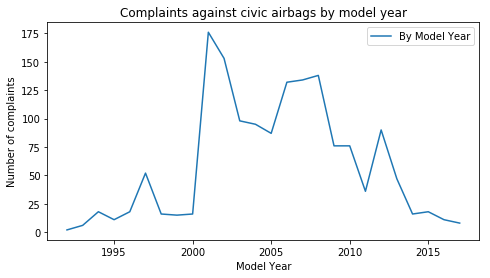

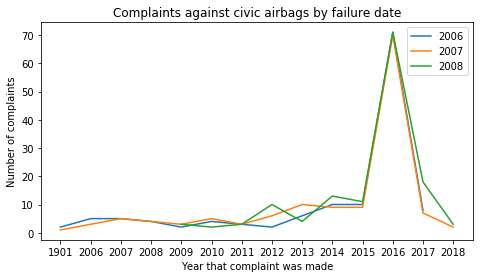

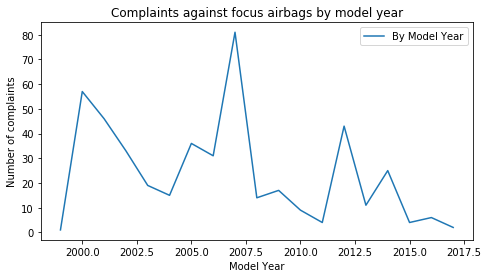

In [13]:
# now lets look at a few different vehicles to see what type of complaints they have, looking 
# at honda civic and ford focus by manufacturing date


df_civic = df_manflist.loc[df_manflist['MODELTXT'].isin(['CIVIC'])]
df_focus = df_manflist.loc[df_manflist['MODELTXT'].isin(['FOCUS'])]

civic_freq = df_civic['COMPDESC'].value_counts()
focus_freq = df_focus['COMPDESC'].value_counts()

civic_AT = df_civic.loc[df_civic['COMPDESC'].isin(['POWER TRAIN:AUTOMATIC TRANSMISSION'])]['YEARTXT'].value_counts()
civic_AirBags = df_civic.loc[df_civic['COMPDESC'].isin(['AIR BAGS'])]['YEARTXT'].value_counts()
civic_AirBags.sort_index(axis=0, inplace=True)
display(civic_AirBags)

focus_AirBags = df_focus.loc[df_focus['COMPDESC'].isin(['AIR BAGS'])]['YEARTXT'].value_counts()
focus_AirBags.sort_index(axis=0, inplace=True)

df_civicAirBags2006 = df_civic.loc[(df_civic['COMPDESC']=='AIR BAGS') & (df_civic['YEARTXT'] == 2006)]
civicAirBags2006 = df_civicAirBags2006['FAILDATE'].value_counts()
civicAirBags2006.sort_index(axis=0, inplace=True)
display(civicAirBags2006)                       

df_civicAirBags2007 = df_civic.loc[(df_civic['COMPDESC']=='AIR BAGS') & (df_civic['YEARTXT'] == 2007)]
civicAirBags2007 = df_civicAirBags2007['FAILDATE'].value_counts()
civicAirBags2007.sort_index(axis=0, inplace=True)
display(civicAirBags2007)   

df_civicAirBags2008 = df_civic.loc[ (df_civic['COMPDESC']=='AIR BAGS') & (df_civic['YEARTXT'] == 2008)]
civicAirBags2008 = df_civicAirBags2008['FAILDATE'].value_counts()
civicAirBags2008.sort_index(axis=0, inplace=True)
display(civicAirBags2008)   

# Plot a graph of failing civics by model year
figsize3 = (15.,4)
plt.figure(figsize=figsize3)
civics, = plt.plot(civic_AirBags.index, civic_AirBags, label='By Model Year')
plt.legend(handles=[civics])
plt.xlabel('Model Year')
plt.ylabel('Number of complaints')
plt.title('Complaints against civic airbags by model year')
fig3 = plt.gcf().subplots_adjust(left=0.5)
plt.show()
plt.draw()
#fig3.savefig('CivicAirbags_bymodelyear.png', type='png', dpi=300, pad_inches=5)
plt.close()

# Plot a graph of failing civics from 2006-2008
figsize2 = (15.,4)
plt.figure(figsize=figsize2)
civic2006, = plt.plot(civicAirBags2006.index, civicAirBags2006, label='2006')
civic2007, = plt.plot(civicAirBags2007.index, civicAirBags2007, label='2007')
civic2008, = plt.plot(civicAirBags2008.index, civicAirBags2008, label='2008')
plt.legend(handles=[civic2006,civic2007,civic2008])
plt.title('Complaints against civic airbags by failure date')
plt.xlabel('Year that complaint was made')
plt.ylabel('Number of complaints')
fig2 = plt.gcf().subplots_adjust(left=0.5)
plt.show()
plt.draw()
#fig2.savefig('CivicAirbags.png', type='png', dpi=300, pad_inches=5)
plt.close()

# Plot a graph of failing focus' by model year
figsize4 = (15.,4)
plt.figure(figsize=figsize4)
focus, = plt.plot(focus_AirBags.index, focus_AirBags, label='By Model Year')
plt.legend(handles=[focus])
plt.xlabel('Model Year')
plt.ylabel('Number of complaints')
plt.title('Complaints against focus airbags by model year')
fig4 = plt.gcf().subplots_adjust(left=0.5)
plt.show()
plt.draw()
#fig3.savefig('FocusAirbags_bymodelyear.png', type='png', dpi=300, pad_inches=5)
plt.close()


#display(civic_freq)
#display(focus_freq)

The first graph here shows the complaints against civic airbags by model year. Complaints against airbags have become much more prevalent between 2000 and 2010. If we take 3 of these years and observe how the trends in the complaints vary over time. For much of the time, complaints number under 10/year. However, in 2016 complaints shoot up. This is likely due to a recall on honda airbags in vehicles made between 2001-2016. In this case, it is likely that recalls caused this drastic rise in complaints. We also see that there is an increase in number of complaints leading up to the recall for all 3 years. This indicates that we will need to consider the time lag between complaints and manufacturing date, if we truly want to understand safety and reliability of a vehicle.

Further, for comparison, if we look at the response of the ford focus. The focus has much fewer complaints - which makes sense because in 2008 its sales were 195,823 compared to the civic's 335,126. However, for the large duration of the time sample, the focus' complaints on airbags are much lower than 2/3 of the Honda Civics. More in depth analysis will be carried out by looking at individual model years and extracting statistics on responses as well as including a large historical sales data set.

The goal here is not only comparison, which I have shown is quite possible, but also prediction. Towards this end I will seek to apply different statistical machine learning techniques such as very basic approaches like arima and possibly more complicated non-linear auto-regressive neural networks to predict the future number of complaints for a given category, where possible. This will empower customers to take a more informed and accessible look at the risks in the car buying process.